In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import sys
import time
import pytorch_lightning as pl
import torchvision
import random
# from scipy.spatial.distance import cdist, directed_hausdorff
from nms import nms
sys.path.append(os.path.join(os.getcwd(), ".."))
#from utils import *
# from Models.unet import UNet
# from Models.splinedist import *
from utils import *
import tqdm
from Datasets.CISD import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
# File format 
import json

def rle2mask(rle):
    values = [i % 2 for i in range(len(rle['counts']))]
    mask = []
    [mask.extend([x] * y) for x,y in zip(values, rle['counts'])]
    return np.array(mask, bool).reshape(rle['size'])

data = json.load(open('../Datasets/CISD/CISD.json'))


In [8]:
data.keys()

dict_keys(['info', 'assets', 'categories'])

In [9]:
data["categories"]

['RED_BLOOD_CELL', 'NEUTROPHIL', 'SUPERFICIAL', 'UROTHELIAL']

In [10]:
data["info"]

{'dataset_name': 'CISD',
 'dataset_type': 'INSTANCE_SEGMENTATION',
 'version': '1.0.0',
 'time_stamp': '2021-05-21 15:46:40.537418',
 'description': 'Cell Instance Segmentation Dataset',
 'img_folder': './CISD'}

In [11]:
data["assets"][0]

{'asset_id': 0,
 'file_name': '0241_BB_01471.jpg',
 'annotations': [{'annotation_id': 2,
   'data': [{'category_name': 'SUPERFICIAL',
     'bbox': [20, 105, 163, 334],
     'mask': {'counts': [7368,
       5,
       22,
       1,
       320,
       17,
       15,
       7,
       313,
       24,
       9,
       13,
       301,
       36,
       4,
       19,
       289,
       76,
       269,
       89,
       263,
       94,
       258,
       99,
       253,
       104,
       245,
       112,
       238,
       120,
       230,
       127,
       226,
       131,
       223,
       133,
       219,
       138,
       216,
       141,
       213,
       144,
       210,
       147,
       206,
       151,
       203,
       154,
       200,
       157,
       196,
       160,
       184,
       4,
       4,
       165,
       180,
       177,
       178,
       178,
       177,
       180,
       174,
       182,
       173,
       183,
       172,
       185,
       170,
       186

In [12]:

data["assets"][0]["annotations"][0]

{'annotation_id': 2,
 'data': [{'category_name': 'SUPERFICIAL',
   'bbox': [20, 105, 163, 334],
   'mask': {'counts': [7368,
     5,
     22,
     1,
     320,
     17,
     15,
     7,
     313,
     24,
     9,
     13,
     301,
     36,
     4,
     19,
     289,
     76,
     269,
     89,
     263,
     94,
     258,
     99,
     253,
     104,
     245,
     112,
     238,
     120,
     230,
     127,
     226,
     131,
     223,
     133,
     219,
     138,
     216,
     141,
     213,
     144,
     210,
     147,
     206,
     151,
     203,
     154,
     200,
     157,
     196,
     160,
     184,
     4,
     4,
     165,
     180,
     177,
     178,
     178,
     177,
     180,
     174,
     182,
     173,
     183,
     172,
     185,
     170,
     186,
     170,
     186,
     169,
     188,
     167,
     189,
     166,
     190,
     165,
     192,
     164,
     193,
     162,
     195,
     160,
     197,
     159,
     198,
     158,
     199,
     157,


In [13]:
# find unique sets : 
# set([ item["set"] for item in data["assets"]])

trainSet = [ item for item in data["assets"] if item["set"] == "train"]
testSet = [ item for item in data["assets"] if item["set"] == "test"]

In [14]:
len(trainSet), len(testSet)

(2933, 978)

In [15]:
root = os.path.join(os.getcwd(), "..", "Datasets", "CISD", "center_slice")

image = cv2.imread(os.path.join(root, trainSet[0]["file_name"]))
masks = [rle2mask(data["mask"]) for data in trainSet[0]["annotations"][0]["data"]]

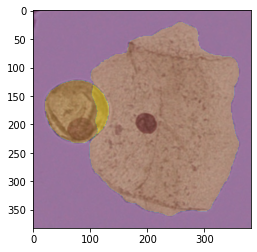

In [16]:
plt.imshow(image)
for mask in masks:
    plt.imshow(mask, alpha=0.3)

In [17]:
datamodule = CISD_datamodule(contourSize=None)

In [23]:
# image = cv2.imread(os.path.join(root, trainSet[0]["file_name"]))
maxContour = 0
contours = []
for i in tqdm.tqdm(range(len(trainSet))):
    masks = [(rle2mask(data["mask"])*255).astype(np.uint8) for data in trainSet[i]["annotations"][0]["data"]]
    
    for mask in masks:
        contour = computeContours(mask, None)
        contours.append(len(contour))
        if len(contour) > maxContour:
            maxContour = len(contour)
            print(maxContour)

  0%|▏                                        | 13/2933 [00:00<00:45, 63.48it/s]

942


  2%|▊                                        | 58/2933 [00:00<00:40, 71.31it/s]

966


 30%|███████████▉                            | 873/2933 [00:14<00:36, 55.87it/s]

972


 38%|██████████████▉                        | 1121/2933 [00:18<00:33, 53.31it/s]

979


 51%|████████████████████                   | 1506/2933 [00:24<00:20, 69.08it/s]

1051


100%|███████████████████████████████████████| 2933/2933 [00:48<00:00, 60.25it/s]


(array([ 20.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          2.,   2.,   0.,   2.,   4.,   2.,   6.,   0.,   0.,   1.,   0.,
          3.,   4.,   5.,   3.,   4.,   3.,   5.,   6.,   4.,   6.,  15.,
         10.,   2.,   3.,   4.,  10.,   9.,   7.,   9.,  11.,   9.,  10.,
          8.,  11.,  12.,  12.,  20.,  26.,  21.,  13.,  19.,  27.,  22.,
         22.,  20.,  33.,  17.,  20.,  22.,  43.,  33.,  29.,  34.,  43.,
         40.,  26.,  50.,  57.,  42.,  44.,  43.,  68.,  58.,  64.,  46.,
         77.,  77.,  59.,  81.,  86.,  75.,  84.,  74.,  96.,  80.,  93.,
         81., 114.,  84.,  97.,  89., 117.,  98.,  95., 102., 100., 106.,
        120., 114., 111., 108., 120., 122., 148., 107., 113., 103., 124.,
        110., 116.,  89., 106., 100.,  99.,  78., 124.,  84.,  81.,  77.,
         89.,  93.,  79.,  82.,  73.,  65.,  56.,  66.,  80.,  55.,  43.,
         32.,  61.,  35.,  46.,  43., 

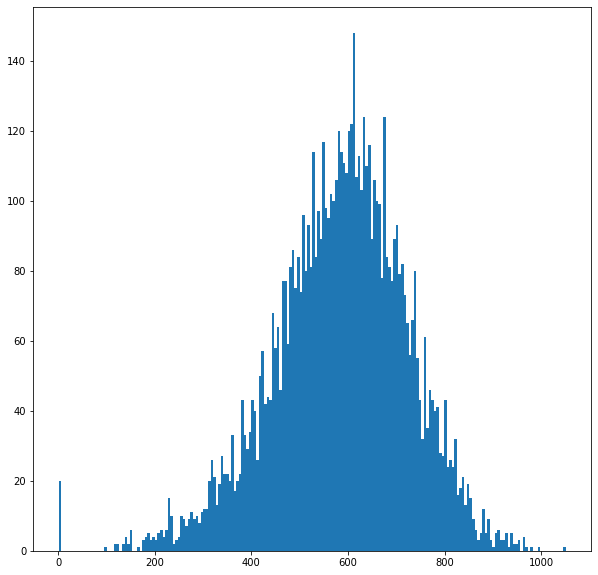

In [27]:
plt.figure(figsize=(10, 10))
plt.hist(contours, 200)

In [13]:
trainDataloader = datamodule.train_dataloader()

In [14]:
batch_x, batch_y = next(iter(trainDataloader))

0.9636169


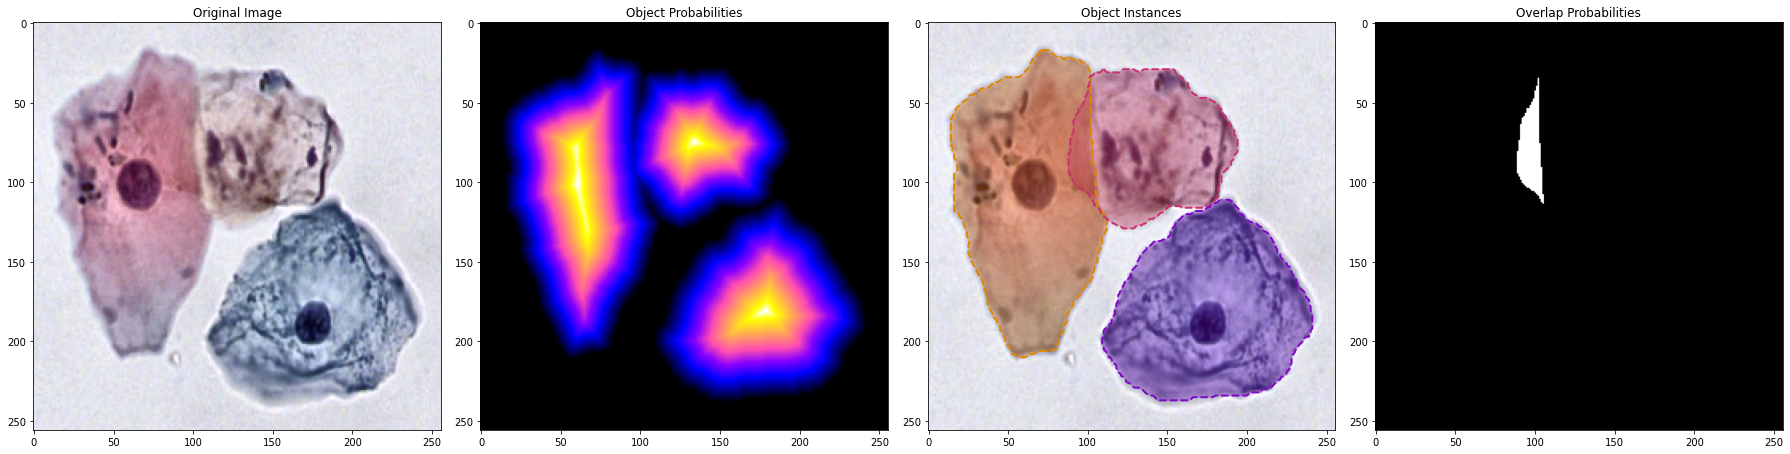

0.9679123


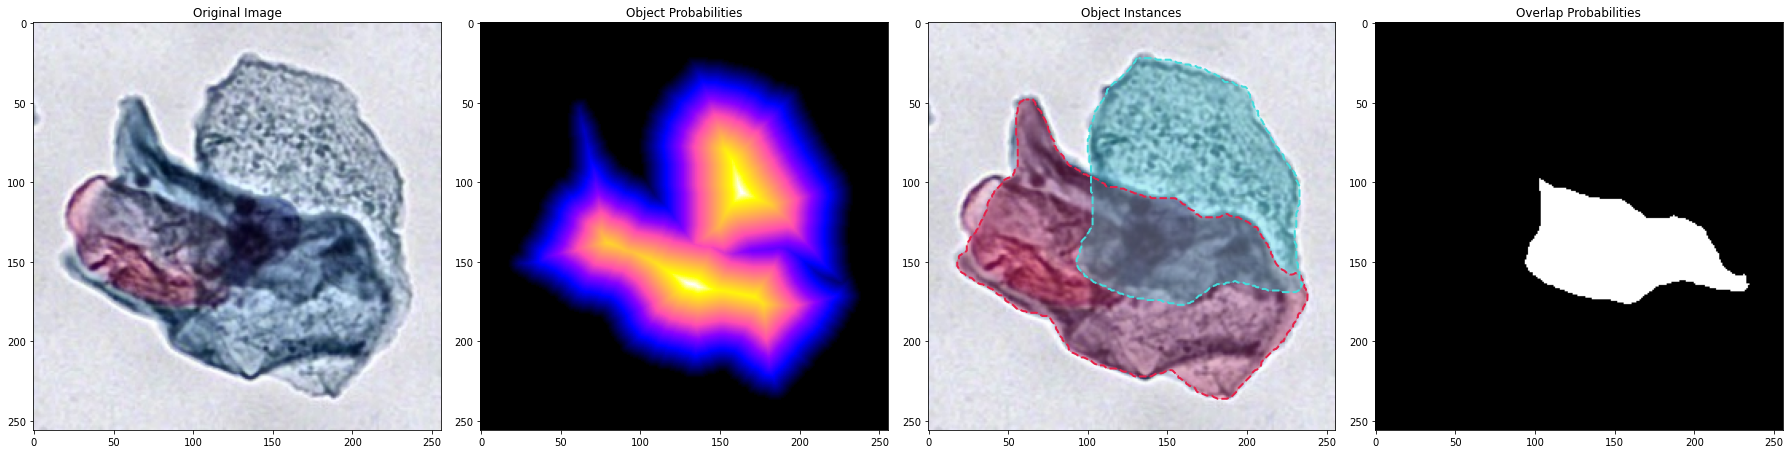

0.9807066


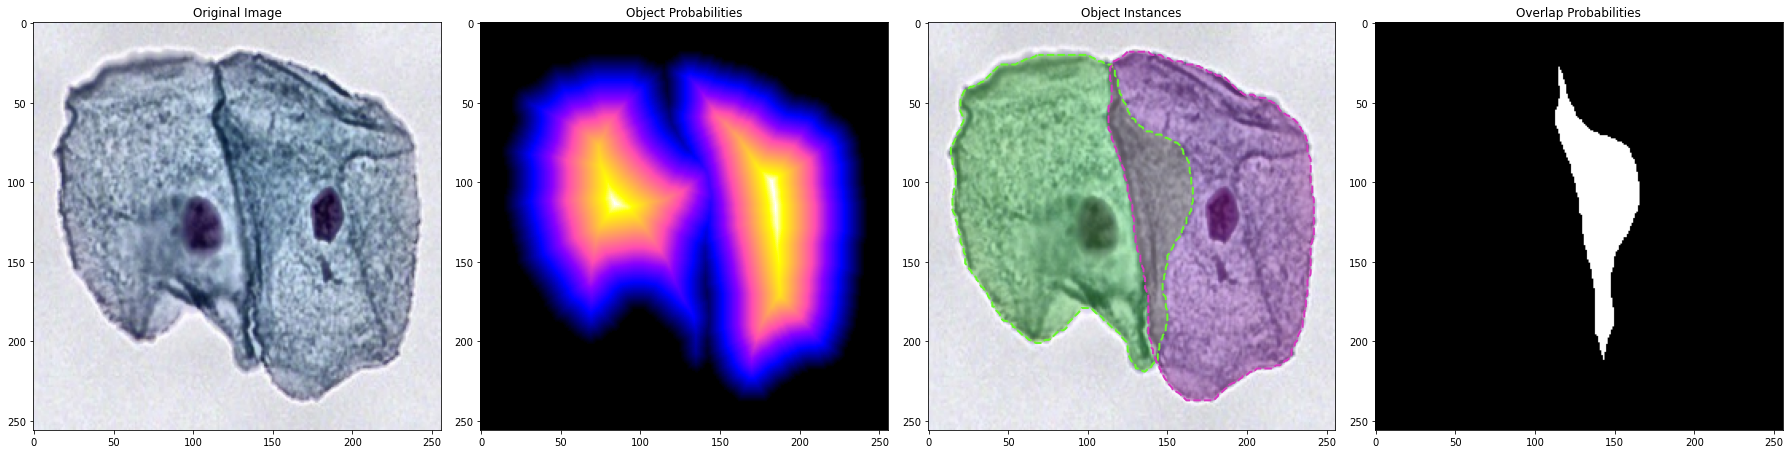

0.98253685


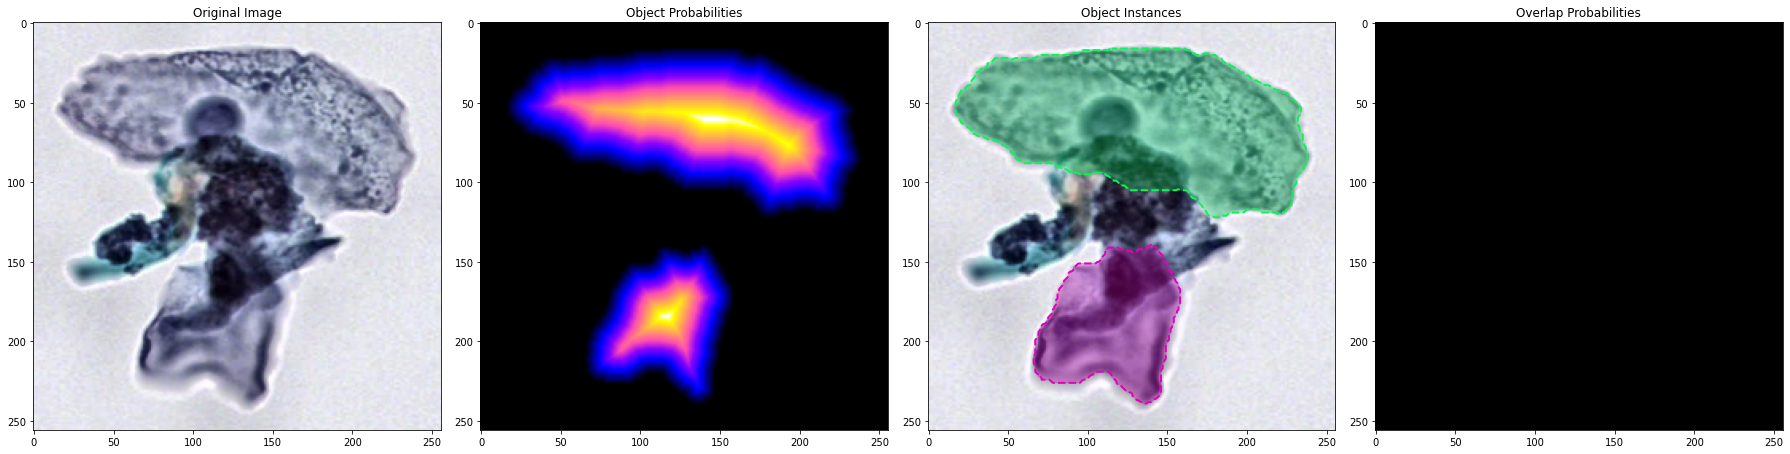

In [15]:
showBatch((batch_x, batch_y))

In [16]:
from torchvision.utils import make_grid
# grid = make_grid(denormalize(batch_x)).numpy().transpose(1, 2, 0)

In [17]:
# plt.imshow(grid)

In [18]:
batches = []
i = 0
for batch in trainDataloader:
    
    if i == 5:
        break
    batches.append(batch[0])
    i = i+1

In [19]:
b = torch.cat(batches)

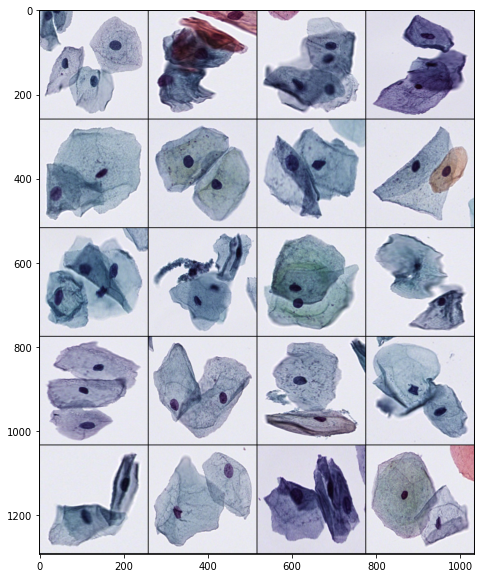

In [22]:
grid = make_grid(denormalize(b), 4).numpy().transpose(1, 2, 0)
plt.figure(figsize=(10, 10))
plt.imshow(grid)